<a href="https://colab.research.google.com/github/swapnilxi/A-computer-vision/blob/main/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# code from udemy course Computer Vision with Python using Deep Learning for Classification

In [1]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:

import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os


In [3]:
# Data augmentation and normalization for training
data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
#Data path
data_dir = "/content/drive/MyDrive/Colab Notebooks/ComputerVision/udemy/Modern_computer_Vision/07-transfer learning/07-Classification Dataset"

# DataSets and Dataloaders

we can either use this or manually pointing
from torch.utils.data import Dataset, DataLoader

In [5]:
from torch.utils.data import Dataset, DataLoader

### Datasets

In [6]:
#Load data
Datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
              for x in ['Train', 'Val']}

The datasets.ImageFolder class expects your data to be organized in a specific folder structure:


```
data_dir/
    Train/
        class_1/
            image_1.jpg
            image_2.jpg
            ...
        class_2/
            image_3.jpg
            image_4.jpg
            ...
        ...
    Val/
        class_1/
            image_5.jpg
            ...
        class_2/
            image_6.jpg
            ...
        ...
 ```       

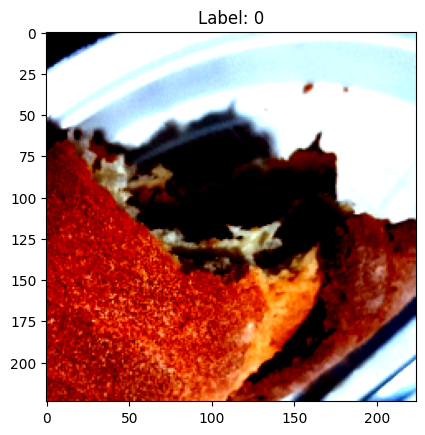

In [7]:
# Get the training dataset
train_dataset = Datasets['Train']

# Access the first image and its label
image, label = train_dataset[2]

# Display the image using matplotlib (assuming you have imported it)
plt.imshow(image.permute(1, 2, 0))  # Permute to change the channel order for display
plt.title(f"Label: {label}")
plt.show()

### DATALOADERS

DataLoaders are a key component of the PyTorch data loading pipeline. They simplify the process of feeding data to your model during training, ensuring efficiency and flexibility by providing **batching**, shuffling, parallel loading, and easy iteration.

In [8]:
#Define Train and Validation Dataloaders
dataloaders = {x: torch.utils.data.DataLoader(Datasets[x], batch_size=5,
                                             shuffle=True, num_workers=0)
              for x in ['Train', 'Val']}

checking the data

In [9]:
### using dictionary in python and can put for loop in same line
dataset_sizes = {x: len(Datasets[x])

for x in ['Train', 'Val']}
print(dataset_sizes)

class_names = Datasets['Val'].classes
print(class_names)

{'Train': 311, 'Val': 50}
['Bread', 'Coffee', 'Pasta']


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Training the model

> model here is - Resnet_fineTuning



In [11]:
def train_model(model, lossFunction, optimizer, scheduler, num_epochs=100):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Val']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = lossFunction(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# train model function call

```
model_fineTuning = train_model(Resnet_fineTuning, Loss_Function, optimizer, Decay_Learning_Rate, num_epochs=20)
torch.save(model_fineTuning, "/content/drive/My Drive/Colab Notebooks/Resnet_fineTuning.pth")
```

> Transpose Dimensions : Changes the shape from (C, H, W) to (H, W, C) because Matplotlib expects the channel dimension last.




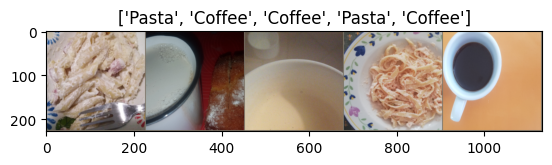

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    #reversing the normalisiation
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])